## Sensitivity analysis
- Partial correlation coefficient (PCC)
- Random Balance Design - Fourier Amplitude Sensitivity Test (RBD-FAST)

In [ ]:
import os
import yaml
from datetime import datetime

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from SALib.analyze import rbd_fast
from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.qualitative import Dark2_4
from palettable.cartocolors.qualitative import Pastel_4

from ideotype.data_process import (read_data, agg_sims, 
                                   fetch_sim_values, parse_mature, fetch_emps)
from ideotype.analysis import identify_top_phenos, rank_all_phenos, rank_top_phenos
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.init_params import params_sample
from ideotype.data_process import agg_sims
from ideotype import DATA_PATH

In [ ]:
# fetch emergent properties
df_emps_present, df_emps_std = fetch_emps('present')
df_emps_f2100, df_emps_std = fetch_emps('f2100')

### Present

In [105]:
# fetch yield mean & disp
run_name = 'present'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

df = df_all
groups = ['cvar', 'site']
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, 'mean', sim)
mx_variance = agg_sims(df, groups, 'variance', sim)
mx_disp = np.divide(mx_variance, mx_mean)

means = mx_mean.flatten()
disps = np.array(mx_disp*-1).flatten()

means = mx_mean.mean(axis=1)
disps = mx_disp.mean(axis=1)*-1
means = np.delete(means, 6) 
disps = np.delete(disps, 6) 

df_pcc = df_emps_present.copy()
df_pcc['mean'] = means
df_pcc['disp'] = disps

In [106]:
# calculate PCC
emps = ['jday', 'pheno_days', 'LA', 'water_deficit_mean', 'An', 'gs', 'edate']

# mean
rs_mean = []
ps = []
cis_mean = []

for item, emp in enumerate(emps):
    covars = emps.copy()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc, x=emp, y='mean',
                          x_covar=covars)
    rs_mean.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_mean.append(pcc['CI95%']['pearson'])
    

# dispersion
rs_disp = []
ps = []
cis_disp = []

for item, emp in enumerate(emps):
    covars = emps.copy()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc, x=emp, y='disp',
                          x_covar=covars)
    rs_disp.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_disp.append(pcc['CI95%']['pearson'])
    
xerrs = []
for item in np.arange(len(emps)):
    xerr = round(cis_mean[item][1] - cis_mean[item][0],2)
    xerrs.append(xerr)

yerrs = []
for item in np.arange(len(emps)):
    yerr = round(cis_disp[item][1] - cis_disp[item][0],2)
    yerrs.append(yerr)
    
# change signs for water deficit for more intuitive interpretation
rs_mean[-4] = rs_mean[-4]*-1
rs_disp[-4] = rs_disp[-4]*-1

rs_mean_present = rs_mean.copy()
rs_disp_present = rs_disp.copy()

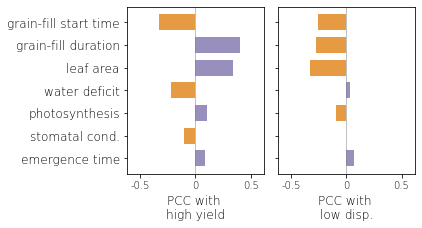

In [107]:
# visualization
fig = plt.figure(figsize=(8,4))

# yield
ax1 = fig.add_subplot(1,2,1)
cc = ['colors']*len(rs_mean)
for n, r in enumerate(rs_mean):
    if r < 0:
        cc[n] = '#e08214'
    if r > 0:
        cc[n] = '#8073ac'

ax1.barh(list(reversed(emps)), list(reversed(rs_mean)), 
         height=0.7, color=list(reversed(cc)), ecolor='grey', alpha=0.8)
ax1.set_xlabel('PCC with \nhigh yield', size=12, fontweight='light')
ax1.set_xlim(-0.62, 0.62)

plt.axvline(x=0, color='grey', linewidth=0.5)
ax1.set_xticks([-0.5,0,0.5])
ax1.set_xticklabels([-0.5,0,0.5], fontweight='light')
ax1.set_yticks(np.arange(len(rs_mean)))
ax1.set_yticklabels(['grain-fill start time',
                     'grain-fill duration',
                     'leaf area',
                     'water deficit',
                     'photosynthesis', 
                     'stomatal cond.',
                     'emergence time'][::-1],
                    fontweight='light', fontsize=12)


# dispersion
ax2 = fig.add_subplot(1,2,2)
cc = ['colors']*len(rs_disp)
for n, r in enumerate(rs_disp):
    if r < 0:
        cc[n] = '#e08214'
    if r > 0: 
        cc[n] = '#8073ac'

ax2.barh(list(reversed(emps_list)), list(reversed(rs_disp)),
         height=0.7, color=list(reversed(cc)), ecolor='grey', alpha=0.8)
ax2.set_xlabel('PCC with \nlow disp.', size=12, fontweight='light')
ax2.set_xlim(-0.62, 0.62)

plt.axvline(x=0, color='grey', linewidth=0.5)
ax2.set_xticks([-0.5,0,0.5])
ax2.set_xticklabels([-0.5,0,0.5], fontweight='light')
ax2.set_yticks(np.arange(len(rs_disp)))
ax2.set_yticklabels(['','','','','','',''])

fig.subplots_adjust(left=0.3, bottom=0.3, wspace=0.1, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_emps.png', format='png', dpi=800)

### F2100

In [108]:
run_name = 'f2100'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

df = df_all.copy()
groups = ['cvar', 'site']
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, 'mean', sim)
mx_variance = agg_sims(df, groups, 'variance', sim)
mx_disp = np.divide(mx_variance, mx_mean)

means = mx_mean.flatten()
disps = np.array(mx_disp*-1).flatten()

means = mx_mean.mean(axis=1)
disps = mx_disp.mean(axis=1)*-1
means = np.delete(means, 6) 
disps = np.delete(disps, 6) 

df_pcc = df_emps_f2100.copy()
df_pcc['mean'] = means
df_pcc['disp'] = disps

In [109]:
emps = ['jday', 'pheno_days', 'LA', 'water_deficit_mean', 'An', 'gs', 'edate']

# mean
rs_mean = []
ps = []
cis_mean = []

for item, emp in enumerate(emps):
    covars = emps.copy()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc, x=emp, y='mean',
                          x_covar=covars)
    rs_mean.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_mean.append(pcc['CI95%']['pearson'])
    

# dispersion
rs_disp = []
ps = []
cis_disp = []

for item, emp in enumerate(emps):
    covars = emps.copy()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc, x=emp, y='disp',
                          x_covar=covars)
    rs_disp.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_disp.append(pcc['CI95%']['pearson'])
    
xerrs = []
for item in np.arange(len(emps)):
    xerr = round(cis_mean[item][1] - cis_mean[item][0],2)
    xerrs.append(xerr)

yerrs = []
for item in np.arange(len(emps)):
    yerr = round(cis_disp[item][1] - cis_disp[item][0],2)
    yerrs.append(yerr)
    
# change signs for water deficit for more intuitive interpretation
rs_mean[-4] = rs_mean[-4]*-1
rs_disp[-4] = rs_disp[-4]*-1

rs_mean_f2100 = rs_mean.copy()
rs_disp_f2100 = rs_disp.copy()

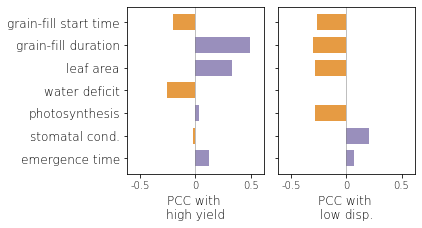

In [110]:
# visualization
fig = plt.figure(figsize=(8,4))

# yield
ax1 = fig.add_subplot(1,2,1)
cc = ['colors']*len(rs_mean)
for n, r in enumerate(rs_mean):
    if r < 0:
        cc[n] = '#e08214'
    if r > 0:
        cc[n] = '#8073ac'

ax1.barh(list(reversed(emps)), list(reversed(rs_mean)), 
         height=0.7, color=list(reversed(cc)), ecolor='grey', alpha=0.8)
ax1.set_xlabel('PCC with \nhigh yield', size=12, fontweight='light')
ax1.set_xlim(-0.62, 0.62)

plt.axvline(x=0, color='grey', linewidth=0.5)
ax1.set_xticks([-0.5,0,0.5])
ax1.set_xticklabels([-0.5,0,0.5], fontweight='light')
ax1.set_yticks(np.arange(len(rs_mean)))
ax1.set_yticklabels(['grain-fill start time',
                     'grain-fill duration',
                     'leaf area',
                     'water deficit',
                     'photosynthesis', 
                     'stomatal cond.',
                     'emergence time'][::-1],
                    fontweight='light', fontsize=12)


# dispersion
ax2 = fig.add_subplot(1,2,2)
cc = ['colors']*len(rs_disp)
for n, r in enumerate(rs_disp):
    if r < 0:
        cc[n] = '#e08214'
    if r > 0: 
        cc[n] = '#8073ac'

ax2.barh(list(reversed(emps_list)), list(reversed(rs_disp)),
         height=0.7, color=list(reversed(cc)), ecolor='grey', alpha=0.8)
ax2.set_xlabel('PCC with \nlow disp.', size=12, fontweight='light')
ax2.set_xlim(-0.62, 0.62)

plt.axvline(x=0, color='grey', linewidth=0.5)
ax2.set_xticks([-0.5,0,0.5])
ax2.set_xticklabels([-0.5,0,0.5], fontweight='light')
ax2.set_yticks(np.arange(len(rs_disp)))
ax2.set_yticklabels(['','','','','','',''])

fig.subplots_adjust(left=0.3, bottom=0.3, wspace=0.1, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_emps.png', format='png', dpi=800)

### Alternative visualization

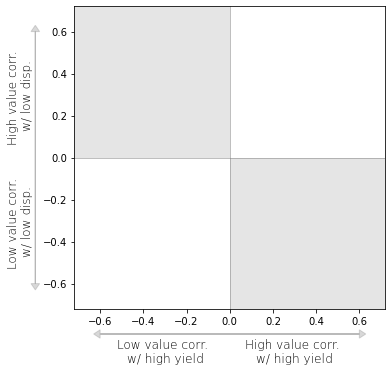

In [317]:
# visualization
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

# plot specs
plt.xlim(-0.72,0.72)
plt.ylim(-0.72,0.72)

# annotations
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)

ax.arrow(-0.6, -0.84, 1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(0.6, -0.84, -1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, -0.6, 0, 1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, 0.6, 0, -1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)

ax.annotate('Low value corr. \nw/ high yield', (-0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ high yield', (0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('Low value corr. \nw/ low disp.', (-0.97, -0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ low disp.', (-0.97, 0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

# antagonistic regions
rect=mpatches.Rectangle((-0.85,0),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,-0.85),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)

fig.subplots_adjust(left=0.18, bottom=0.18)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_pcc_yield_disp_emp_blank_shading.png', format='png', dpi=800)

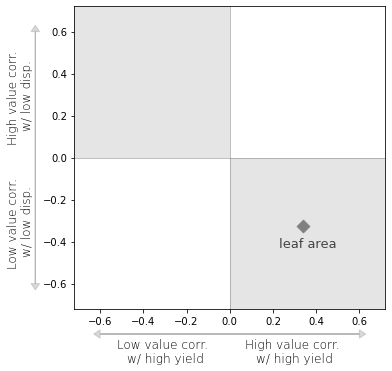

In [320]:
# visualization
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

markers = ['>', 'v', '^', '*', 'o', 'D', 'X']
sizes = [0, 0, 0, 0, 0, 80, 0]

for item in np.arange(len(rs_mean)):
    ax.scatter(rs_mean[item], rs_disp[item],
               color='grey', s=sizes[item], 
               marker=markers[item])

# annotate
emps_text = ['grain-fill \nduration', 'grain-fill \nstart time', 'emergence time', 
             'photosynthesis', 'stomatal \nconduct.', 'leaf area', 'water deficit']

x_adjust = [0.04, -0.11, 0.05, 0.06, -0.12, -0.11, -0.17]
y_adjust = [-0.05, -0.17, -0.02, -0.02, -0.16, -0.1, 0.06]
ax.annotate(emps_text[-2], (rs_mean[-2] + x_adjust[-2], 
                  rs_disp[-2] + y_adjust[-2]),
            size=13, alpha=0.7)
# plot specs
plt.xlim(-0.72,0.72)
plt.ylim(-0.72,0.72)

# annotations
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)

ax.arrow(-0.6, -0.84, 1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(0.6, -0.84, -1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, -0.6, 0, 1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, 0.6, 0, -1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)

ax.annotate('Low value corr. \nw/ high yield', (-0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ high yield', (0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('Low value corr. \nw/ low disp.', (-0.97, -0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ low disp.', (-0.97, 0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

# antagonistic regions
rect=mpatches.Rectangle((-0.85,0),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,-0.85),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)

fig.subplots_adjust(left=0.18, bottom=0.18)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_pcc_yield_disp_emp_example.png', format='png', dpi=800)

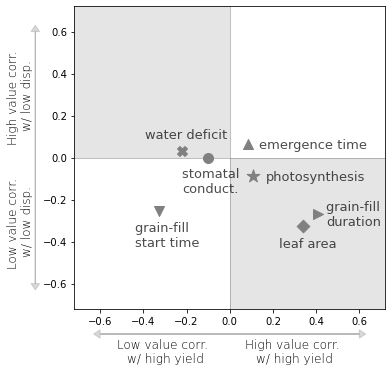

In [305]:
# visualization
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

markers = ['>', 'v', '^', '*', 'o', 'D', 'X']
sizes = [100, 100, 100, 180, 100, 80, 100]

for item in np.arange(len(rs_mean)):
    ax.scatter(rs_mean[item], rs_disp[item],
               color='grey', s=sizes[item], 
               marker=markers[item])

# annotate
emps_text = ['grain-fill \nduration', 'grain-fill \nstart time', 'emergence time', 
             'photosynthesis', 'stomatal \nconduct.', 'leaf area', 'water deficit']

x_adjust = [0.04, -0.11, 0.05, 0.06, -0.12, -0.11, -0.17]
y_adjust = [-0.05, -0.17, -0.02, -0.02, -0.16, -0.1, 0.06]
for count, emp in enumerate(emps_text):
    ax.annotate(emp, (rs_mean[count] + x_adjust[count], 
                      rs_disp[count] + y_adjust[count]),
                size=13, alpha=0.7)
# plot specs
plt.xlim(-0.72,0.72)
plt.ylim(-0.72,0.72)

# annotations
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)

ax.arrow(-0.6, -0.84, 1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(0.6, -0.84, -1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, -0.6, 0, 1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, 0.6, 0, -1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)

ax.annotate('Low value corr. \nw/ high yield', (-0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ high yield', (0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('Low value corr. \nw/ low disp.', (-0.97, -0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ low disp.', (-0.97, 0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

# antagonistic regions
rect=mpatches.Rectangle((-0.85,0),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,-0.85),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)

fig.subplots_adjust(left=0.18, bottom=0.18)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_pcc_yield_disp_emp.png', format='png', dpi=800)

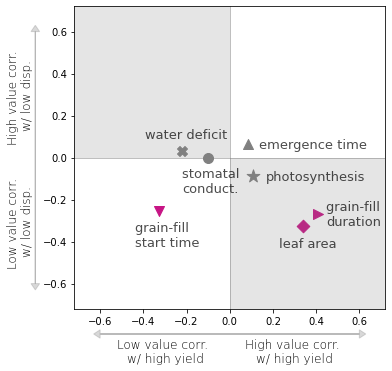

In [313]:
# visualization
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

markers = ['>', 'v', '^', '*', 'o', 'D', 'X']
sizes = [100, 100, 100, 180, 100, 80, 100]
#c1 = 'deeppink'
c1 = 'mediumvioletred'
c2 = 'grey'
colors = [c1,c1,c2,c2,c2,c1,c2]

for item in np.arange(len(rs_mean)):
    ax.scatter(rs_mean[item], rs_disp[item],
               color=colors[item], s=sizes[item], 
               marker=markers[item])

# annotate
emps_text = ['grain-fill \nduration', 'grain-fill \nstart time', 'emergence time', 
             'photosynthesis', 'stomatal \nconduct.', 'leaf area', 'water deficit']

x_adjust = [0.04, -0.11, 0.05, 0.06, -0.12, -0.11, -0.17]
y_adjust = [-0.05, -0.17, -0.02, -0.02, -0.16, -0.1, 0.06]
for count, emp in enumerate(emps_text):
    ax.annotate(emp, (rs_mean[count] + x_adjust[count], 
                      rs_disp[count] + y_adjust[count]),
                size=13, alpha=0.7)
# plot specs
plt.xlim(-0.72,0.72)
plt.ylim(-0.72,0.72)

# annotations
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)

ax.arrow(-0.6, -0.84, 1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(0.6, -0.84, -1.2, 0, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, -0.6, 0, 1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)
ax.arrow(-0.9, 0.6, 0, -1.2, color='grey', alpha=0.3,
         head_length=0.03, head_width=0.04, clip_on=False)

ax.annotate('Low value corr. \nw/ high yield', (-0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ high yield', (0.3,-0.92), 
            ha='center', va='center', fontweight='light', fontsize=12,
            annotation_clip=False)
ax.annotate('Low value corr. \nw/ low disp.', (-0.97, -0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('High value corr. \nw/ low disp.', (-0.97, 0.3), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

# antagonistic regions
rect=mpatches.Rectangle((-0.85,0),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,-0.85),0.85, 0.85, 
                        facecolor='grey', alpha=0.2)
plt.gca().add_patch(rect)

fig.subplots_adjust(left=0.18, bottom=0.18)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_pcc_yield_disp_emp_highlighted.png', format='png', dpi=800)

## PCC plots with data points across all sites

In [409]:
# grain-fill start date & duration
df_pheno_grouped = df_phenology[
    df_phenology.pheno == '"grainFill"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','pheno_days', 'jday']]

# pdate
df_pheno_gdate = df_phenology[
    df_phenology.pheno == '"Germinated"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','jday']]
df_pheno_gdate.columns = ['cvar','site','gdate']
df_pheno_grouped = df_pheno_grouped.merge(df_pheno_gdate, how='left', on=['cvar','site'])

# photosynthesis & gs
df_phys_grouped = df_phys[
    df_phys.pheno=='"grainFill"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','An', 'gs']]

# leaf area
df_leaves_grouped = df_leaves[
    df_leaves.pheno == '"Tasselinit"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','LA']]
df_leaves_grouped['mean'] = means
df_leaves_grouped['disp'] = disps

# merge all
df_pcc = df_pheno_grouped.merge(df_phys_grouped, how='left', on=['cvar','site'])
df_pcc = df_pcc.merge(df_leaves_grouped, how='left', on=['cvar', 'site'])

In [411]:
rs_mean = []
ps = []
cis_mean = []

emps = df_pcc.columns[2:8]

for item, emp in enumerate(emps):
    covars = emps.tolist()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc, x=emp, y='mean',
                          x_covar=covars)
    rs_mean.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_mean.append(pcc['CI95%']['pearson'])
    
rs_disp = []
ps = []
cis_disp = []

emps = df_pcc.columns[2:8]

for item, emp in enumerate(emps):
    covars = emps.tolist()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc, x=emp, y='disp',
                          x_covar=covars)
    rs_disp.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_disp.append(pcc['CI95%']['pearson'])
    
xerrs = []
for item in np.arange(len(emps)):
    xerr = round(cis_mean[item][1] - cis_mean[item][0],2)
    xerrs.append(xerr)

yerrs = []
for item in np.arange(len(emps)):
    yerr = round(cis_disp[item][1] - cis_disp[item][0],2)
    yerrs.append(yerr)

## PCC plots clustered by sites

In [9]:
df_climate = df_all.groupby('site').mean()[['temp', 'vpd', 'precip']]
df_climate_std = StandardScaler().fit_transform(df_climate)

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate_std)
y_kmeans = kmeans_mod.predict(df_climate_std)

df_cluster = df_climate.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

df_sites.site = df_sites.site.astype(int)
df_clustered_sites = pd.merge(df_cluster, df_sites, left_on='site', right_on='site')

In [10]:
sites = df_km3.index.tolist()
df_pcc_subsites = df_pcc[df_pcc.site.isin(sites)]

In [11]:
rs_mean = []
ps = []
cis_mean = []

emps = df_pcc_subsites.columns[2:8]

for item, emp in enumerate(emps):
    covars = emps.tolist()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc_subsites, x=emp, y='mean',
                          x_covar=covars)
    rs_mean.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_mean.append(pcc['CI95%']['pearson'])
    
rs_disp = []
ps = []
cis_disp = []

for item, emp in enumerate(emps):
    covars = emps.tolist()
    covars.remove(emp)
    pcc = pg.partial_corr(df_pcc_subsites, x=emp, y='disp',
                          x_covar=covars)
    rs_disp.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis_disp.append(pcc['CI95%']['pearson'])
    
xerrs = []
for item in np.arange(len(emps)):
    xerr = round(cis_mean[item][1] - cis_mean[item][0],2)
    xerrs.append(xerr)

yerrs = []
for item in np.arange(len(emps)):
    yerr = round(cis_disp[item][1] - cis_disp[item][0],2)
    yerrs.append(yerr)

(-0.7, 0.7)

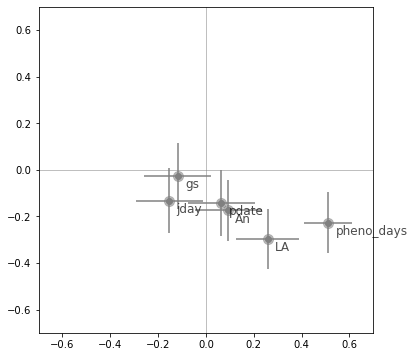

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.errorbar(rs_mean, rs_disp, 
            xerr=xerrs, yerr=yerrs, fmt='o', color='grey')

ax.scatter(rs_mean, rs_disp,
            color='grey', s=100, alpha=0.5)

for count, emp in enumerate(emps):
    ax.annotate(emp, (rs_mean[count]+0.03, rs_disp[count]-0.05),
                size=12, alpha=0.7)

ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)

plt.xlim(-0.7,0.7)
plt.ylim(-0.7,0.7)

Text(0.5, 1.0, 'Clustered sites')

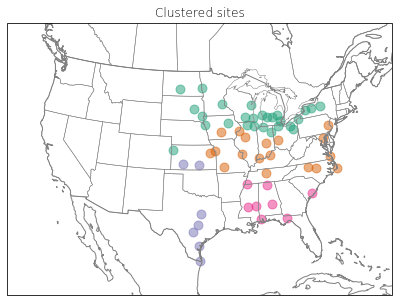

In [13]:
df_km0_sites = pd.merge(df_km0, df_sites, on='site')
df_km1_sites = pd.merge(df_km1, df_sites, on='site')
df_km2_sites = pd.merge(df_km2, df_sites, on='site')
df_km3_sites = pd.merge(df_km3, df_sites, on='site')
fig = plt.figure(figsize=(8,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
mp = ax.scatter(df_km0_sites.lon, df_km0_sites.lat, 
                color=Dark2_4.mpl_colors[2], # purple
                s=80, alpha=0.5, transform=ccrs.PlateCarree())
mp = ax.scatter(df_km1_sites.lon, df_km1_sites.lat, 
                color=Dark2_4.mpl_colors[1], # orange
                s=80, alpha=0.5, transform=ccrs.PlateCarree())
mp = ax.scatter(df_km2_sites.lon, df_km2_sites.lat, 
                color=Dark2_4.mpl_colors[0], # green
                s=80, alpha=0.5, transform=ccrs.PlateCarree())
mp = ax.scatter(df_km3_sites.lon, df_km3_sites.lat, 
                color=Dark2_4.mpl_colors[3], # pink
                s=80, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Clustered sites', fontweight='light', size=12)

#fig.colorbar(mp, shrink=0.5)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/map_clustered_sites.png', format='png', dpi=800)

### Partial Correlation Coefficient

In [122]:
# set up mean
df_mean = df_all.groupby(['cvar','site']).mean().dm_ear
df_mean = df_mean.reset_index()
df_mean = df_mean.merge(df_params, how='left', on='cvar')

# Set up dispersion
df_disp = (df_all.groupby(['cvar','site']).var().dm_ear) / (df_all.groupby(['cvar','site']).mean().dm_ear)
df_disp = df_disp.reset_index()
df_disp = df_disp.merge(df_params, how='left', on='cvar')

# make dispersion negative for more intuitive interpretation in PCC results
df_disp.dm_ear = df_disp.dm_ear*-1 

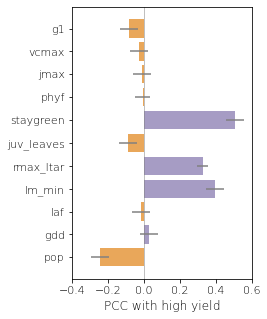

In [126]:
params_list = list(df_params.columns[:-1])
rs_mean = []
ps = []
cis = []

for item in np.arange(11):
    param = params_list[item]
    select = list(np.arange(11))
    select.remove(item)
    params_sub = [params_list[item] for item in select]
    pcc = pg.partial_corr(df_mean, x=param, y='dm_ear',
                          x_covar=params_sub)
    rs_mean.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis.append(pcc['CI95%']['pearson'])

# set error bars
errs_mean = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

# set bar colors
cc = ['colors']*len(rs_mean)
for n, r in enumerate(rs_mean):
    if r < 0:
        cc[n] = '#e08214'
    if r > 0:
        cc[n] = '#8073ac'

# visualization
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.barh(list(reversed(params_list)), 
        list(reversed(rs_mean)), 
        color=list(reversed(cc)),
        xerr=errs_mean, ecolor='grey', alpha=0.7)
ax.set_xlabel('PCC with high yield', size=12, fontweight='light')
ax.set_xlim(-0.4, 0.6)

plt.axvline(x=0, color='grey', linewidth=0.5)
plt.xticks(fontsize=11, weight='light')
plt.yticks(fontsize=11, weight='light')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_mean.png', format='png', dpi=800)

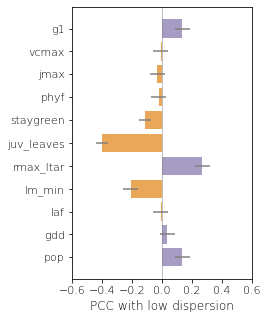

In [127]:
params_list = list(df_params.columns[:-1])
rs_disp = []
ps = []
cis = []

for item in np.arange(11):
    param = params_list[item]
    select = list(np.arange(11))
    select.remove(item)
    params_sub = [params_list[item] for item in select]
    pcc = pg.partial_corr(df_disp, x=param, y='dm_ear',
                          x_covar=params_sub)
    rs_disp.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis.append(pcc['CI95%']['pearson'])

# set error bars
errs_disp = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

# set bar colors
cc = ['colors']*len(rs_disp)
for n, r in enumerate(rs_disp):
    if r > 0:
        cc[n] = '#8073ac'
    if r < 0:
        cc[n] = '#e08214'

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.barh(list(reversed(params_list)), 
        list(reversed(rs_disp)), 
        color=list(reversed(cc)),
        xerr=errs_disp, ecolor='grey', alpha=0.7)
ax.set_xlim(-0.6, 0.6)
ax.set_xlabel('PCC with low dispersion', size=12, fontweight='light')

plt.axvline(x=0, color='grey', linewidth=0.5)
plt.xticks(fontsize=11, weight='light')
plt.yticks(fontsize=11, weight='light')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_disp.png', format='png', dpi=800)

Text(0, 0.5, 'PCC with low dispersion')

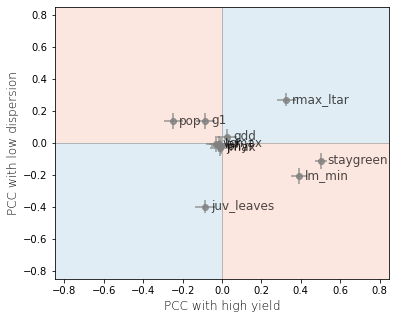

In [125]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)

# synergistic regions
rect=mpatches.Rectangle((-0.85,-0.85),0.85, 0.85, 
                        facecolor='#67a9cf', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,0),0.85, 0.85, 
                        facecolor='#67a9cf', alpha=0.2)
plt.gca().add_patch(rect)

# antagonistic regions
rect=mpatches.Rectangle((-0.85,0),0.85, 0.85, 
                        facecolor='#ef8a62', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,-0.85),0.85, 0.85, 
                        facecolor='#ef8a62', alpha=0.2)
plt.gca().add_patch(rect)

# scatter points
ax.errorbar(rs_mean, rs_disp, 
            xerr=errs_mean, yerr=errs_disp, 
            fmt='o', color='grey', alpha=0.8)
#ax.scatter(rs_mean, rs_disp,
#            color='grey', s=80)


#ax.scatter(rs_mean, rs_disp, s=150, color='grey', alpha=0.8)
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)
for count, item in enumerate(params_list):
    ax.annotate(item, (rs_mean[count]+0.03, rs_disp[count]-0.02),
                size=12, alpha=0.7)
ax.set_xlim(-0.85,0.85)
ax.set_ylim(-0.85,0.85)
ax.set_xlabel('PCC with high yield', fontweight='light', size=12)
ax.set_ylabel('PCC with low dispersion', fontweight='light', size=12)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_pcc_yield_disp.png', format='png', dpi=800)

Text(0, 0.5, 'PCC with low dispersion')

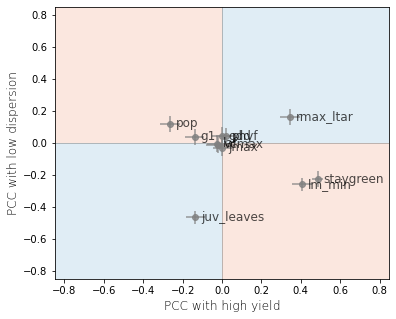

In [301]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)

# synergistic regions
rect=mpatches.Rectangle((-0.85,-0.85),0.85, 0.85, 
                        facecolor='#67a9cf', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,0),0.85, 0.85, 
                        facecolor='#67a9cf', alpha=0.2)
plt.gca().add_patch(rect)

# antagonistic regions
rect=mpatches.Rectangle((-0.85,0),0.85, 0.85, 
                        facecolor='#ef8a62', alpha=0.2)
plt.gca().add_patch(rect)
rect=mpatches.Rectangle((0,-0.85),0.85, 0.85, 
                        facecolor='#ef8a62', alpha=0.2)
plt.gca().add_patch(rect)

# scatter points
ax.errorbar(rs_mean, rs_disp, 
            xerr=errs_mean, yerr=errs_disp, 
            fmt='o', color='grey', alpha=0.8)
#ax.scatter(rs_mean, rs_disp,
#            color='grey', s=80)


#ax.scatter(rs_mean, rs_disp, s=150, color='grey', alpha=0.8)
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)
for count, item in enumerate(params_list):
    ax.annotate(item, (rs_mean[count]+0.03, rs_disp[count]-0.02),
                size=12, alpha=0.7)
ax.set_xlim(-0.85,0.85)
ax.set_ylim(-0.85,0.85)
ax.set_xlabel('PCC with high yield', fontweight='light', size=12)
ax.set_ylabel('PCC with low dispersion', fontweight='light', size=12)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_pcc_yield_disp.png', format='png', dpi=800)

### RBD-FAST
Note: SI values should not be negative, I think this suggests that sample size is not enough.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

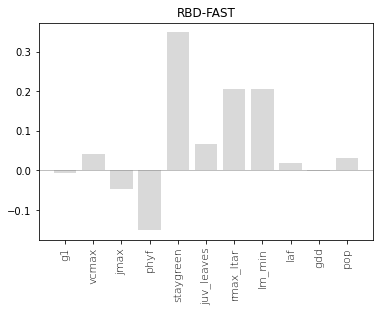

In [14]:
problem, param_values = params_sample('present', 100)
df_params = df_params[:100]
ear = df_all.groupby('cvar').mean().dm_ear

X = df_params.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.bar(params_list, Si['S1'], color='#d9d9d9')
ax.set_title('RBD-FAST')

plt.axhline(y=0, color='grey', linewidth=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

### Where to add in scatter plot type analyses?
Also can't find where the old code is used to plot it..

### Cluster based on site-year climate info
- Treating each site-year as individual samples
- One down side with treating each site-year as individuals is that it's hard to relate to the clustered groups. Can't project back onto a map.
- Can think about tweaking what features to use to cluster sites, but I don't think it'll make a big difference.
- Q: should I pre-process before clustering?

In [6]:
#df_climate = df_all[['temp', 'temp_var', 'vpd', 'rh_var', 'precip', 'precip_var', 'solrad']]
df_climate = df_all[['temp', 'vpd', 'precip']]
df_climate_std = StandardScaler().fit_transform(df_climate)

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate_std)
y_kmeans = kmeans_mod.predict(df_climate_std)

df_cluster = df_all.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

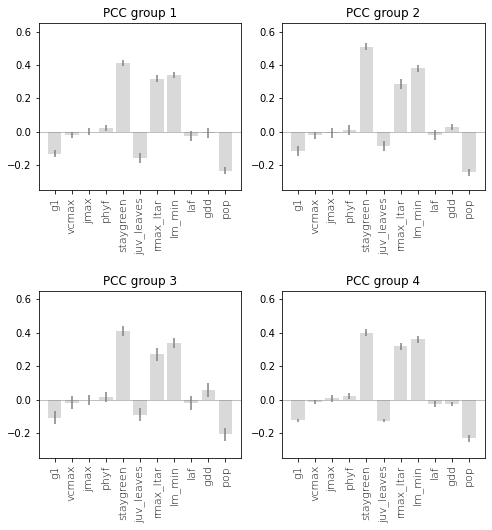

In [7]:
df_kms = [df_km0, df_km1, df_km2, df_km3]
params_list = list(df_params.columns[:-1])

fig = plt.figure(figsize=(8,8))

for num in np.arange(len(df_kms)):
    rs = []
    ps = []
    cis = []
    ax = fig.add_subplot(2,2,num+1)
    
    for item in np.arange(11):
        param = params_list[item]
        select = list(np.arange(11))
        select.remove(item)
        params_sub = [params_list[item] for item in select]
        pcc = pg.partial_corr(df_kms[num], x=param, y='dm_ear',
                              x_covar=params_sub)
        rs.append(pcc['r']['pearson'])
        ps.append(pcc['p-val']['pearson'])
        cis.append(pcc['CI95%']['pearson'])

    errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

    ax.bar(params_list, rs, color='#d9d9d9',
           yerr=errs, ecolor='grey')
    ax.set_title(f'PCC group {num+1}')
    ax.set_ylim(-0.35, 0.65)

    plt.axhline(y=0, color='grey', linewidth=0.5)
    plt.xticks(rotation=90, fontsize=11, weight='light')

fig.subplots_adjust(wspace=0.2, hspace=0.6)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_cspace.png', format='png', dpi=800)